En este notebook resumiré en una única celda todo lo hecho en la prueba 3 donde creabamos el dataframe que vamos a emplear en este notebook. 

Y a continuación probaremos todos los algóritmos de machinelearning aprendidos para ver cuál es el que mejor se adapta a nuestros datos.
Es probable que también usemos técnicas de reducción de dimensionalidad así como de visualización.

In [1]:
import pandas as pd
dd = pd.read_csv('../../Archivos_tfm/dataTesting/usuarios_DD_1809a1110.csv')
dd.columns = ['ID','Usuarios'] # Cambiamos el nombre de la columna.
dd.drop('Usuarios',1, inplace=True) # Eliminamos la columna usuarios, ya que no la vamos a necesitar.

profundidad = pd.read_csv('../../Archivos_tfm/dataTesting/profundidad.csv', index_col=0)
profundidad.drop('page', 1, inplace=True)
profundidad.drop('neutral_metric', 1, inplace=True)# Eliminamos esas columnas que no necesitamos
def countUsers(lista): # Definimos la función que cálcula la profundidad.
    """
    method para contar veces que aparece un usuario
    inputs:
        *lista: lista de usuarios
    output: diccionario de {'ID usuario':profundidad en el proceso}
    """
    hist = {} # Creamos un diccionario vacío
    for user in lista:
        if user in hist:
            hist[user] += 1
        else:
            hist[user] = 1
    return hist
dict_user = countUsers(profundidad['ID']) # aplicamos la función a nuestra lista de usuarios
profundidad = pd.DataFrame(dict_user.items(), columns=['ID','Profundidad']) # Diccionario a dataframe
dd = pd.merge(dd,profundidad, on = 'ID') # UNIMOS TABLAS

navigation_data = pd.read_csv('../../Archivos_tfm/dataTesting/usersFeatures_1809a1110.csv') #
navigation_data.columns = ['ID','sesiones','visualizaciones','visualizacionesUnicas','duracionMediaSesion']
dd = pd.merge(dd, navigation_data, on = 'ID') # Añadimos datos de navegación generales

# Cálculo de características básicas
dd['visualizacionesPorSesion'] = (dd['visualizaciones']/dd['sesiones']) # New feature
dd['visualizacionesUnicasPorSesion'] = (dd['visualizacionesUnicas']/dd['sesiones']) # New feature

# Cuatro características más
timepage1 = pd.read_csv('../../Archivos_tfm/dataTesting/Tiempo1_1809a1110.csv')
timepage1.columns = ['ID','avgTimePage1']
timepage2 = pd.read_csv('../../Archivos_tfm/dataTesting/Tiempo2_1809a1110.csv')
timepage2.columns = ['ID','avgTimePage2']
timepage3 = pd.read_csv('../../Archivos_tfm/dataTesting/Tiempo3_1809a1110.csv')
timepage3.columns = ['ID','avgTimePage3']
# UNIMOS TABLAS
dd = pd.merge(dd, timepage1, how='left', on='ID')
dd = pd.merge(dd, timepage2, how='left', on='ID')
dd = pd.merge(dd, timepage3, how='left', on='ID')

# No queremos tener en cuenta los usuarios cuyo tiempo en la primera página es NaN.
dd = dd[dd['avgTimePage1'].notnull()]

# Añadimos una columna más que sea la suma de las tres anteriores.
# Obtenemos por tanto el tiempo medio que cada usuario a empleado en el proceso.
dd = dd.fillna(0) # Para poder sumar debemos sustituir los NaNs por cero.
dd['avgTimeInTheProcess'] = dd['avgTimePage1'] + dd['avgTimePage2'] + dd['avgTimePage3']

# Y otra columa que sea el tiempo que está fuera del proceso
dd['avgTimeOutOfTheProcess'] = dd['duracionMediaSesion'] - dd['avgTimeInTheProcess']

# Añadimos un par de columnas más con datos de visitas a la primera, segunda y tercera página del proceso.
processViews = (pd.read_csv('../../Archivos_tfm/dataTesting/visualizacionespantallasproceso_1809a1110.csv',
                            index_col=0))
dd = (pd.merge(dd, processViews[processViews['page']=='page1'].drop('page',1).
         rename(columns = {'PageProcessViews':'visitsToTheProcess',
                           'uniquePageProcessViews':'uniqueVisitsToTheProcess'}),
                            how='left', on = 'ID')) # visitas página uno
dd = (pd.merge(dd, processViews[processViews['page']=='page2'].drop('page',1).
         rename(columns = {'PageProcessViews':'visitsPage2',
                           'uniquePageProcessViews':'uniqueVisitsPage2'}),
                            how='left', on = 'ID')) # visitas página dos
dd = (pd.merge(dd, processViews[processViews['page']=='page3'].drop('page',1).
               rename(columns = {'PageProcessViews':'visitsPage3',
                                 'uniquePageProcessViews':'uniqueVisitsPage3'}), how='left', on = 'ID'))
dd = dd.fillna(0)

In [2]:
# ETIQUETAS
dd['Y'] = dd['Profundidad']
dd['Y'] = (dd['Y'].replace(to_replace=[4,3,2,1],
           value=[1,0,0,0]))

In [3]:
dd.head(5)

,ID,Profundidad,sesiones,visualizaciones,visualizacionesUnicas,duracionMediaSesion,visualizacionesPorSesion,visualizacionesUnicasPorSesion,avgTimePage1,avgTimePage2,avgTimePage3,avgTimeInTheProcess,avgTimeOutOfTheProcess,visitsToTheProcess,uniqueVisitsToTheProcess,visitsPage2,uniqueVisitsPage2,visitsPage3,uniqueVisitsPage3,Y
0,F10001681,1,3,53,16,1246.333333,17.666667,5.333333,10.0,0.000000,0.0,10.000000,1236.333333,1,1,0.0,0.0,0.0,0.0,0
1,F10004567,1,111,1419,409,167.756757,12.783784,3.684685,3.0,0.000000,0.0,3.000000,164.756757,1,1,0.0,0.0,0.0,0.0,0
2,F10007287,4,68,935,301,155.485294,13.750000,4.426471,8.8,7.333333,0.0,16.133333,139.351961,10,6,4.0,3.0,2.0,1.0,1
3,F10019099,4,10,111,48,112.500000,11.100000,4.800000,18.0,5.000000,16.0,39.000000,73.500000,1,1,1.0,1.0,1.0,1.0,1
4,F10020552,1,3,48,15,140.333333,16.000000,5.000000,14.0,0.000000,0.0,14.000000,126.333333,1,1,0.0,0.0,0.0,0.0,0


# Reducción de dimensionalidad

## TSNE

In [4]:
from sklearn.manifold import TSNE

In [5]:
X = (dd[dd.columns[1:18]])
X = X.sample(5000).values
#y = dd['Y']
model = TSNE()
Xb = model.fit_transform(X)

In [7]:
Xb

array([[ -4.46318564,  -5.54674886],
       [  0.4895659 ,   2.16525872],
       [  1.58451678,  -8.41145624],
       ..., 
       [  8.86310436,  -4.95413163],
       [ 10.56597446,   1.61839909],
       [ -7.61027568,  11.28791105]])

# Pruebas algoritmos machine learning

- Primero añadimos una columna con las etiquetas
1. K-Neighbour
2. Support Vector Machines
3. Decision Tree
4. Random forest

In [3]:
# ETIQUETAS
dd['Y'] = dd['Profundidad']
dd['Y'] = (dd['Y'].replace(to_replace=[4,3,2,1],
           value=[1,0,0,0]))

# 1. K-Neighbour

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

X = (dd[dd.columns[1:18]].values)
y = dd['Y']
clf = KNeighborsClassifier()
clf.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [9]:
# Prueba con train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)
clf = KNeighborsClassifier(n_neighbors=3)
print clf.fit(X_train,y_train)
print accuracy_score(y_test,clf.predict(X_test))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
0.838752312979


In [10]:
print cross_val_score(clf,X,y,cv=30)
print cross_val_score(clf,X,y,cv=30).mean()

[ 0.83168317  0.86930693  0.85346535  0.87128713  0.83366337  0.84356436
  0.82376238  0.88712871  0.84554455  0.87128713  0.86732673  0.86138614
  0.83168317  0.86336634  0.84950495  0.84554455  0.85714286  0.8452381
  0.85119048  0.8452381   0.85714286  0.83531746  0.83928571  0.86706349
  0.84691849  0.82107356  0.85487078  0.86083499  0.83300199  0.85685885]
0.850689421541


(array([  4.,   7.,   8.,  13.,  15.,  21.,  17.,   7.,   3.,   5.]),
 array([ 0.78666667,  0.79939073,  0.81211479,  0.82483885,  0.83756291,
         0.85028698,  0.86301104,  0.8757351 ,  0.88845916,  0.90118322,
         0.91390728]),
 <a list of 10 Patch objects>)

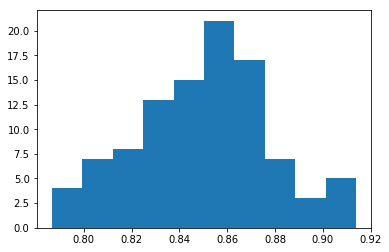

In [11]:
plt.hist(cross_val_score(clf,X,y,cv=100))

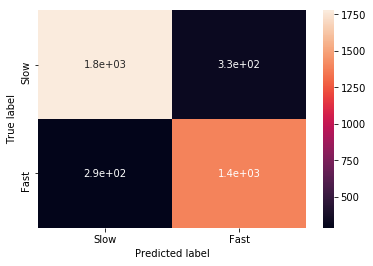

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test,clf.predict(X_test))
dfmat = pd.DataFrame(mat,index = ["Slow","Fast"],
                  columns = ["Slow","Fast"])
sns.heatmap(dfmat,annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score
print ["Slow","Fast"]
print precision_score(y_test,clf.predict(X_test),average=None)
print recall_score(y_test,clf.predict(X_test),average=None)
print f1_score(y_test,clf.predict(X_test),average=None)

['Slow', 'Fast']
[ 0.86101695  0.80791618]
[ 0.84345351  0.82865672]
[ 0.85214474  0.81815503]


In [12]:
# Accuracy Score according to the number of neighbors
scores=[]
for i in range(1,40):
    clf = KNeighborsClassifier(n_neighbors=i)
    scores.append(cross_val_score(clf,X,y,cv=3))

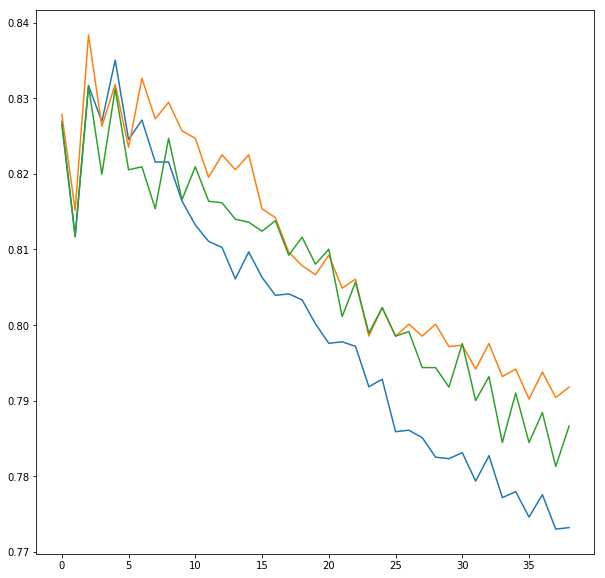

In [13]:
plt.figure(figsize=(10,10))
plt.plot(scores)
plt.show()

In [14]:
from sklearn.model_selection import GridSearchCV
nclf = KNeighborsClassifier()
clf = GridSearchCV(nclf,param_grid={"n_neighbors":range(1,50)},scoring='precision')
clf.fit(X,y)
print clf.best_params_

{'n_neighbors': 2}


# Support Vector Machines

In [46]:
from sklearn.svm import SVC
X = (dd[dd.columns[1:19]].values)
y = dd['Y']
clf = SVC()
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
clf = SVC(kernel='linear')
clf.fit(X_train,y_train)
print accuracy_score(y_test,clf.predict(X_test))

1.0


In [55]:
cross_val_score(clf,X,y,cv=15)

array([ 1.        ,  1.        ,  0.99900892,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ])

In [53]:
# Kernel rbf
# print cross_val_score(clf,X,y,cv=30)
# print cross_val_score(clf,X,y,cv=30).mean()

[ 0.56039604  0.56039604  0.56237624  0.56237624  0.56237624  0.56633663
  0.56039604  0.56039604  0.56237624  0.56039604  0.56039604  0.56237624
  0.56039604  0.56039604  0.56039604  0.56039604  0.55952381  0.56150794
  0.55952381  0.55952381  0.56150794  0.56150794  0.55952381  0.55952381
  0.56063618  0.56063618  0.56063618  0.56063618  0.56063618  0.56262425]
0.561004208132


# Decision tree

In [56]:
from sklearn import tree
X = (dd[dd.columns[1:18]].values)
y = dd['Y']
clf = tree.DecisionTreeClassifier()
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
clf = tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)
print accuracy_score(y_test,clf.predict(X_test))

1.0


In [58]:
cross_val_score(clf,X,y,cv=15)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.])

In [62]:
accuracy_score(y_test,clf.predict(X_test))

1.0

#  Random forest

In [25]:
#from sklearn.ensemble import RandomForestClassifier
X = (dd[dd.columns[2:19]].values)
y = dd['Y']
clf = RandomForestClassifier(oob_score=True, random_state=42)
clf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

In [26]:
clf.oob_score_

0.96920026437541307

In [27]:
clf.feature_importances_

array([ 0.00349063,  0.00574146,  0.00480032,  0.00502495,  0.00543167,
        0.0056131 ,  0.00598592,  0.14994972,  0.11872546,  0.04727915,
        0.0047409 ,  0.00319279,  0.00182926,  0.03129701,  0.07505441,
        0.11811543,  0.41372782])

<Container object of 17 artists>

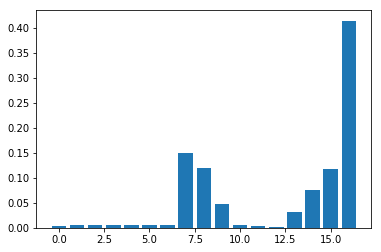

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.bar(range(len(clf.feature_importances_)),clf.feature_importances_)

In [16]:
dd.columns

Index([u'ID', u'Profundidad', u'sesiones', u'visualizaciones',
       u'visualizacionesUnicas', u'duracionMediaSesion',
       u'visualizacionesPorSesion', u'visualizacionesUnicasPorSesion',
       u'avgTimePage1', u'avgTimePage2', u'avgTimePage3',
       u'avgTimeInTheProcess', u'avgTimeOutOfTheProcess',
       u'visitsToTheProcess', u'uniqueVisitsToTheProcess', u'visitsPage2',
       u'uniqueVisitsPage2', u'visitsPage3', u'uniqueVisitsPage3', u'Y'],
      dtype='object')

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
clf = RandomForestClassifier(oob_score=True, random_state=42)
print clf.fit(X_train,y_train)
print accuracy_score(y_test,clf.predict(X_test))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)
0.982553528945


In [31]:
print cross_val_score(clf,X,y,cv=30)
print cross_val_score(clf,X,y,cv=30).mean()

[ 0.98613861  0.97623762  0.97821782  0.97623762  0.96435644  0.97029703
  0.98217822  0.98811881  0.97821782  0.97425743  0.98217822  0.98811881
  0.97227723  0.98613861  0.98415842  0.98811881  0.9781746   0.98015873
  0.9702381   0.98809524  0.97619048  0.98214286  0.9781746   0.99007937
  0.9860835   0.98011928  0.98409543  0.9860835   0.9860835   0.97614314]
0.980570328097


In [ ]:
plt.hist(cross_val_score(clf,X,y,cv=100))